# SIFT
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/YoniChechik/AI_is_Math/blob/master/c_08_features/sift.ipynb)



In [1]:
# to run in google colab
import sys
if 'google.colab' in sys.modules:
    import subprocess
    subprocess.call("pip install -U opencv-python".split())
    subprocess.call("wget https://raw.githubusercontent.com/YoniChechik/AI_is_Math/master/c_08_features/left.jpg".split())
    subprocess.call("wget https://raw.githubusercontent.com/YoniChechik/AI_is_Math/master/c_08_features/right.jpg".split())



SIFT code is adapted from:
https://towardsdatascience.com/image-stitching-using-opencv-817779c86a83


In [2]:
from random import randrange
import matplotlib.pyplot as plt
import numpy as np
import cv2
figsize = (10, 10)


In [3]:
rgb_l = cv2.cvtColor(cv2.imread("left.jpg"), cv2.COLOR_BGR2RGB)
gray_l = cv2.cvtColor(rgb_l, cv2.COLOR_RGB2GRAY)
rgb_r = cv2.cvtColor(cv2.imread("right.jpg"), cv2.COLOR_BGR2RGB)
gray_r = cv2.cvtColor(rgb_r, cv2.COLOR_RGB2GRAY)



## SIFT feature detection and description


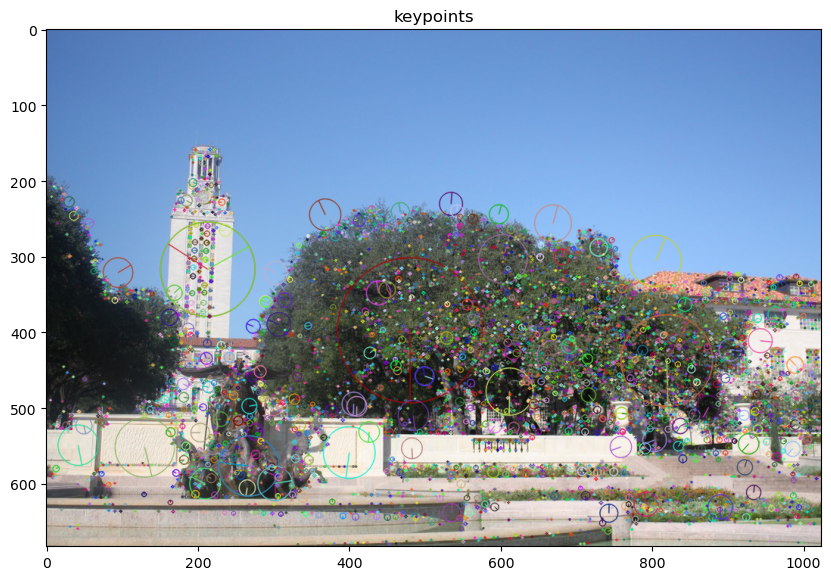

In [4]:
# use orb if sift is not installed
feature_extractor = cv2.SIFT_create()

# find the keypoints and descriptors with chosen feature_extractor
kp_l, desc_l = feature_extractor.detectAndCompute(gray_l, None)
kp_r, desc_r = feature_extractor.detectAndCompute(gray_r, None)

test = cv2.drawKeypoints(rgb_l, kp_l, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.figure(figsize=figsize)
plt.imshow(test)
plt.title("keypoints")
plt.show()



## take only unique features


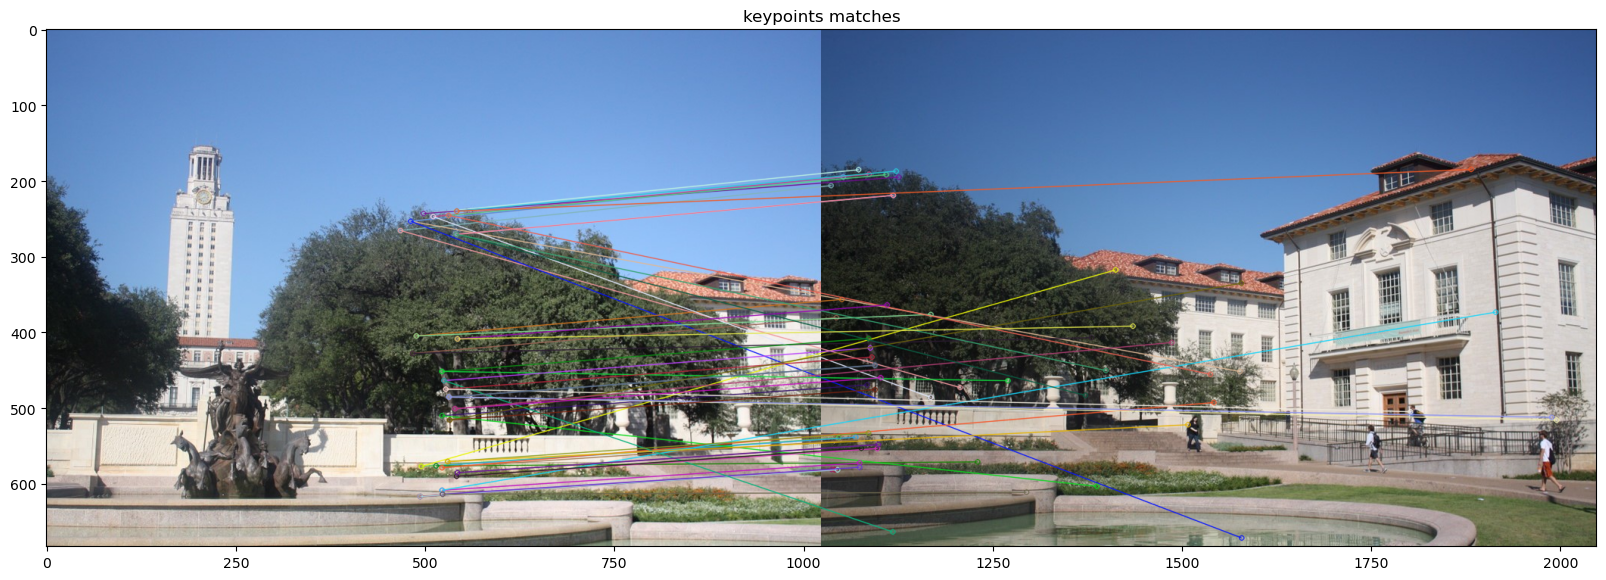

In [5]:
bf = cv2.BFMatcher()
matches = bf.knnMatch(desc_l, desc_r, k=2)

# Apply ratio test
good_and_second_good_match_list = []
for m in matches:
    if m[0].distance/m[1].distance < 0.5:
        good_and_second_good_match_list.append(m)
good_match_arr = np.asarray(good_and_second_good_match_list)[:,0]

# show only 30 matches
im_matches = cv2.drawMatchesKnn(rgb_l, kp_l, rgb_r, kp_r,
                                good_and_second_good_match_list[0:30], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(20, 20))
plt.imshow(im_matches)
plt.title("keypoints matches")
plt.show()



## find homography between images


In [6]:
good_kp_l = np.array([kp_l[m.queryIdx].pt for m in good_match_arr])
good_kp_r = np.array([kp_r[m.trainIdx].pt for m in good_match_arr])
H, masked = cv2.findHomography(good_kp_r, good_kp_l, cv2.RANSAC, 5.0)

print(H)


[[ 7.66113524e-01  3.52741445e-02  4.46996388e+02]
 [-1.34989563e-01  9.10628561e-01  7.62880394e+01]
 [-2.09763712e-04 -3.43883926e-05  1.00000000e+00]]


## overlay images


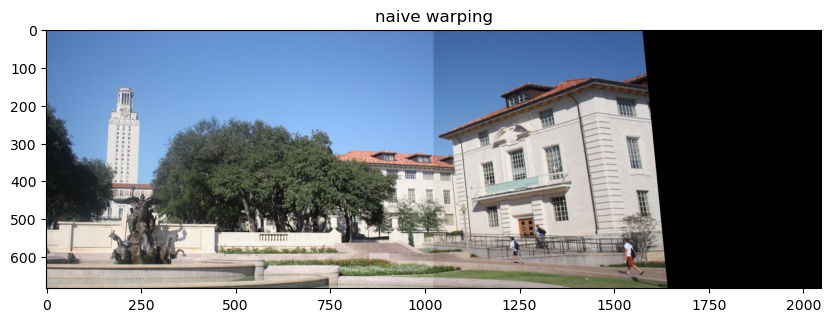

In [7]:
rgb_r_warped = cv2.warpPerspective(rgb_r, H, (rgb_l.shape[1] + rgb_r.shape[1], rgb_l.shape[0]))
rgb_r_warped[0:rgb_l.shape[0], 0:rgb_l.shape[1]] = rgb_l

plt.figure(figsize=figsize)
plt.imshow(rgb_r_warped)
plt.title("naive warping")
plt.show()


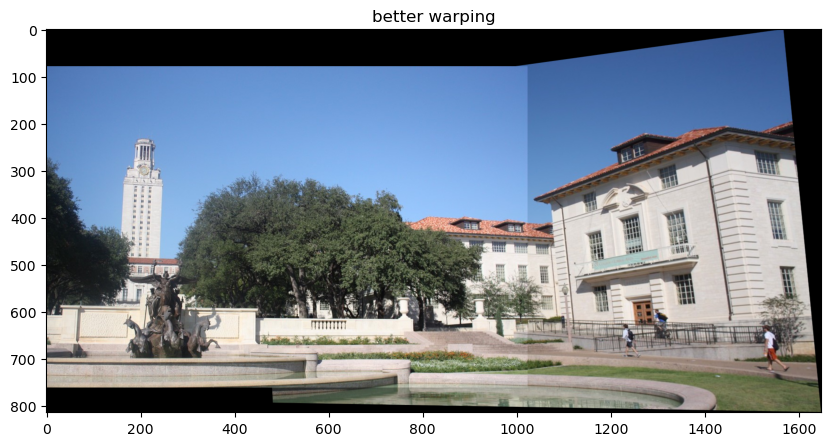

In [8]:


def warpTwoImages(img1, img2, H):
    '''warp img2 to img1 with homograph H
    from: https://stackoverflow.com/questions/13063201/how-to-show-the-whole-image-when-using-opencv-warpperspective
    '''
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]
    pts1 = np.float32([[0, 0], [0, h1], [w1, h1], [w1, 0]]).reshape(-1, 1, 2)
    pts2 = np.float32([[0, 0], [0, h2], [w2, h2], [w2, 0]]).reshape(-1, 1, 2)
    pts2_ = cv2.perspectiveTransform(pts2, H)
    pts = np.concatenate((pts1, pts2_), axis=0)
    [xmin, ymin] = np.int32(pts.min(axis=0).ravel() - 0.5)
    [xmax, ymax] = np.int32(pts.max(axis=0).ravel() + 0.5)
    t = [-xmin, -ymin]
    Ht = np.array([[1, 0, t[0]], [0, 1, t[1]], [0, 0, 1]])  # translate

    result = cv2.warpPerspective(img2, Ht@H, (xmax-xmin, ymax-ymin))
    result[t[1]:h1+t[1], t[0]:w1+t[0]] = img1
    return result


result = warpTwoImages(rgb_l, rgb_r, H)

plt.figure(figsize=figsize)
plt.imshow(result)
plt.title("better warping")
plt.show()

